In [1]:
import torch
from torch import optim
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

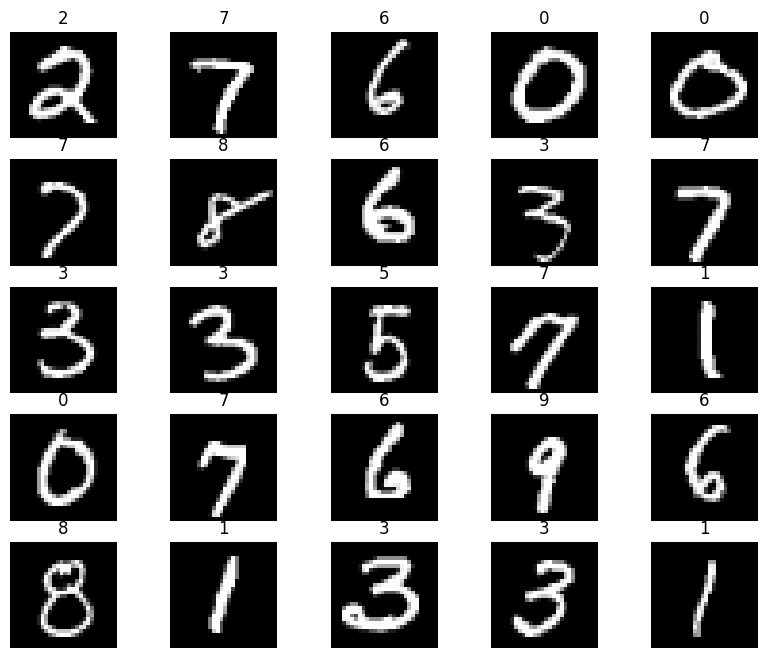

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
loaders = {'train' : torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True,num_workers=1),
                                                  'test'  : torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4f909136a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f4f7a0935b0>}

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [8]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [9]:
def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    losses = [0]
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            losses.append(loss.item())
    plt.figure()
    plt.plot(losses)
    plt.title('Training Loss')
    plt.show()

Epoch [1/2], Step [100/600], Loss: 0.1346
Epoch [1/2], Step [200/600], Loss: 0.0354
Epoch [1/2], Step [300/600], Loss: 0.0545
Epoch [1/2], Step [400/600], Loss: 0.0979
Epoch [1/2], Step [500/600], Loss: 0.0816
Epoch [1/2], Step [600/600], Loss: 0.0813
Epoch [2/2], Step [100/600], Loss: 0.0105
Epoch [2/2], Step [200/600], Loss: 0.0350
Epoch [2/2], Step [300/600], Loss: 0.0603
Epoch [2/2], Step [400/600], Loss: 0.0537
Epoch [2/2], Step [500/600], Loss: 0.0801
Epoch [2/2], Step [600/600], Loss: 0.0264


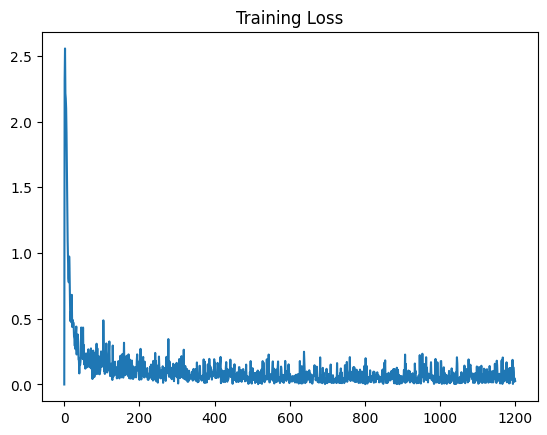

In [10]:
num_epochs = 2     
train(num_epochs, cnn, loaders)

In [11]:
def test(model):
    # Test the model
    model.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    cols,rows = 5,5
    sample = next(iter(loaders['test']))
    imgs, lbls = sample
    test_output, last_layer = model(imgs[:cols * rows])
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
    
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(cols * rows):
        figure.add_subplot(rows, cols, i+1)
        plt.title(pred_y[i])
        plt.axis("off")
        plt.imshow(imgs[i].squeeze(), cmap="gray")
    plt.show()
# test()

Test Accuracy of the model on the 10000 test images: 0.99


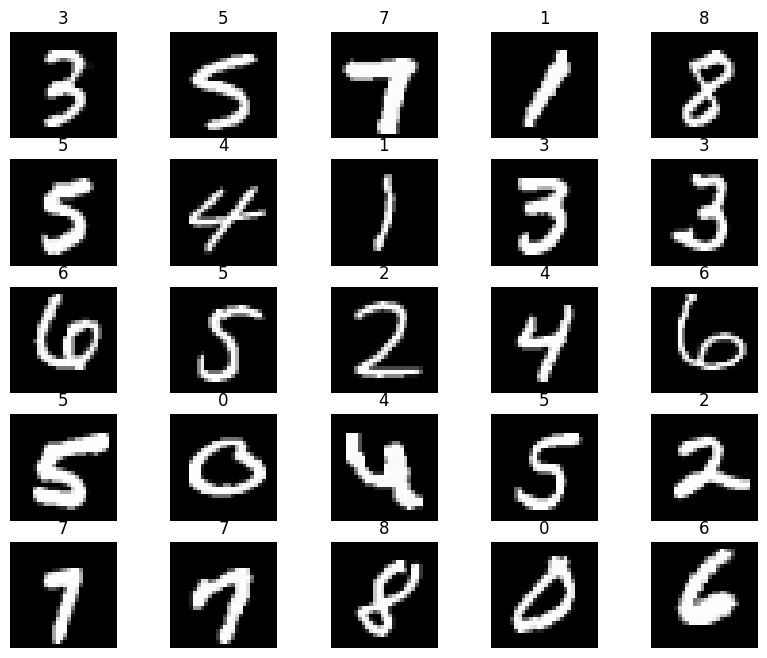

In [19]:
test(cnn)

In [ ]:
class FlattenNN(nn.Module):
    def __init__(self,rows,cols):
        super().__init__()        
        self.layer0 = nn.Sequential(nn.Flatten(),
                                nn.Linear(rows*cols, 1024),
                                nn.ReLU())
        self.layer1 = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU())
        self.out = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x) 
        output = self.out(x)
        return output, x    # return x for visualization

flat = FlattenNN(28,28)
print(flat)

Epoch [1/2], Step [100/600], Loss: 0.2348
Epoch [1/2], Step [200/600], Loss: 0.1737
Epoch [1/2], Step [300/600], Loss: 0.1700
Epoch [1/2], Step [400/600], Loss: 0.1442
Epoch [1/2], Step [500/600], Loss: 0.0649
Epoch [1/2], Step [600/600], Loss: 0.0792
Epoch [2/2], Step [100/600], Loss: 0.0950
Epoch [2/2], Step [200/600], Loss: 0.2098
Epoch [2/2], Step [300/600], Loss: 0.0283
Epoch [2/2], Step [400/600], Loss: 0.1278
Epoch [2/2], Step [500/600], Loss: 0.0696
Epoch [2/2], Step [600/600], Loss: 0.0916


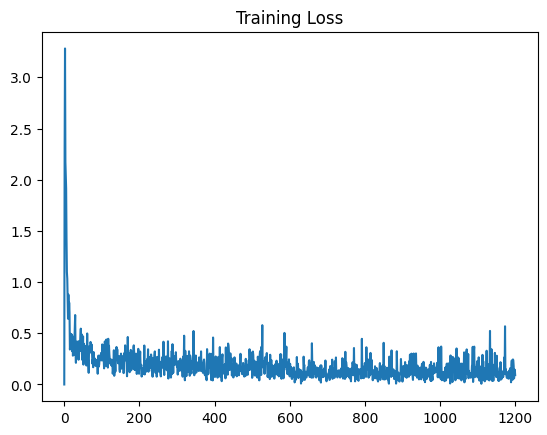

In [13]:
num_epochs = 2
flat = FlattenNN(28,28)
optimizer = optim.Adam(flat.parameters(), lr = 0.01)   
train(num_epochs, flat, loaders)

Test Accuracy of the model on the 10000 test images: 0.95


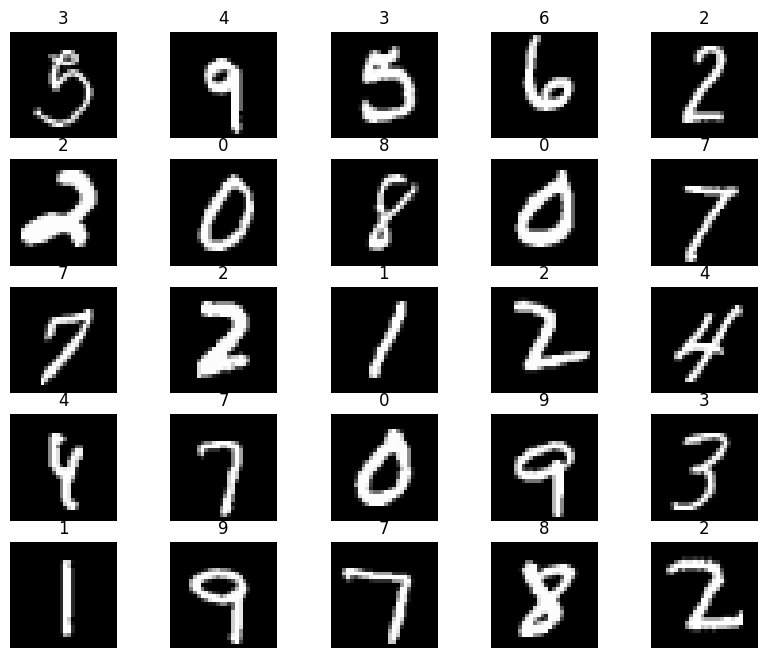

In [14]:
test(flat)

In [15]:
from modules import NonSpikingLayer, ChemicalSynapse, PiecewiseActivation

In [16]:
class SNS(nn.Module):
    def __init__(self,rows,cols):
        super().__init__()   
        self.flat = nn.Flatten()
        self.layer0 = nn.Sequential(nn.Flatten(),
                                nn.Linear(rows*cols, 1024))
        self.pre = NonSpikingLayer(1024)
        self.synapse = ChemicalSynapse(1024,256)
        self.post = NonSpikingLayer(256)
        self.out = nn.Sequential(PiecewiseActivation(),
                                 nn.Linear(256, 10))
        
    def forward(self, x):
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.layer0(x)
        # print(x.shape)
        x = self.pre(x)
        # print(x.shape)
        # print(self.post.state_0.unsqueeze(1).shape)
        x = self.synapse(x,self.post.state_0)
        x = self.post(x)
        output = self.out(x)
        return output, x    # return x for visualization

sns = SNS(28,28)
print(sns)

SNS(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
  )
  (pre): NonSpikingLayer()
  (synapse): ChemicalSynapse(
    (activation): PiecewiseActivation()
  )
  (post): NonSpikingLayer()
  (out): Sequential(
    (0): PiecewiseActivation()
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


Epoch [1/2], Step [100/600], Loss: 0.3849
Epoch [1/2], Step [200/600], Loss: 0.2127
Epoch [1/2], Step [300/600], Loss: 0.3288
Epoch [1/2], Step [400/600], Loss: 0.2603
Epoch [1/2], Step [500/600], Loss: 0.3221
Epoch [1/2], Step [600/600], Loss: 0.1656
Epoch [2/2], Step [100/600], Loss: 0.2467
Epoch [2/2], Step [200/600], Loss: 0.1924
Epoch [2/2], Step [300/600], Loss: 0.1444
Epoch [2/2], Step [400/600], Loss: 0.2781
Epoch [2/2], Step [500/600], Loss: 0.4020
Epoch [2/2], Step [600/600], Loss: 0.1327


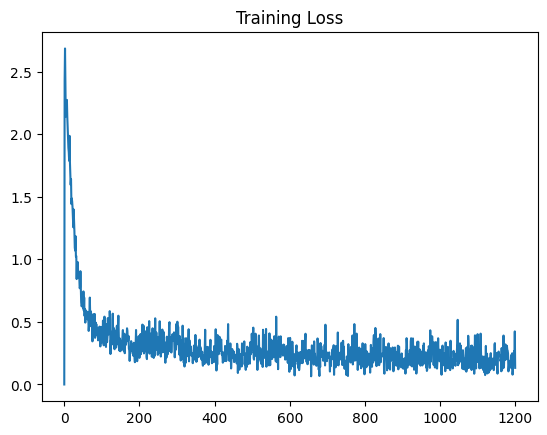

In [17]:
num_epochs = 2
sns = SNS(28,28)
optimizer = optim.Adam(sns.parameters(), lr = 0.01)   
train(num_epochs, sns, loaders)

Test Accuracy of the model on the 10000 test images: 0.99


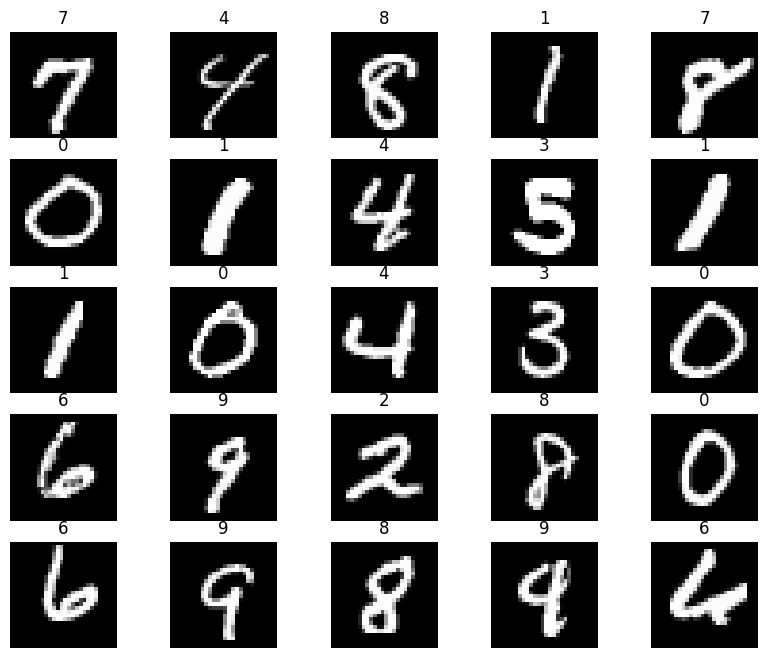

In [18]:
test(sns)